In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy
import random
from functions import *
from wordcloud import WordCloud
from textblob import TextBlob
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from scipy.stats import norm

# Table of Contents
[Import Data](#import)<br>
[Publisher and Political Leaning Distribution](#distribution)<br>
[Reliability and Bias Distribution](#bias)<br>
[Word Count](#wordcount)<br>
[Data Normalization](#normalization)<br>
[Topic Modeling](#topics)<br>
[Word Clouds](#wordcloud)<br>
[Sentiment Analysis - Polarity](#sentiment)<br>

# Import Data<a id="import"></a>

The scraped news data are stored in a series of CSV files. The `gather_csv` function is used to gather all CSV files, remove duplicates, and return the final dataset. In the process, each publisher's bias and reliability scores are retried from AdFontes Media and each document is tagged as right/left/middle depending on the bias score. These scores are also saved as dicitonaries. The `middle` parameter is set to `True` here, so publishers with bias scores between -6 and 6 are tagged as "Middle" leaning. The "Middle" category is used only for EDA and is not intended to be used in the actual classification portion of the project.

In [2]:
dframe, adfontes_bias, adfontes_reliability = gather_csv(middle=True)

# Publisher and Political Leaning Distribution<a id="distribution"></a>

## Articles By Publisher

The dataset is broken down by the number of articles per publisher:

In [3]:
value_counts_percentage(df=dframe, feature="Source")

,Counts,Fraction,Percentage
NY Post,338,0.226238,22.62%
CNN,281,0.188086,18.81%
Fox News,225,0.150602,15.06%
OAN,196,0.131191,13.12%
Associated Press,167,0.111780,11.18%
Palmer Report,152,0.101740,10.17%
The Daily Beast,56,0.037483,3.75%
Occupy Democrats,40,0.026774,2.68%
Epoch Times,39,0.026104,2.61%


New York Post has the most articles in the dataset, comprising about a quarter of the total data. Occupy Democrats and Epoch TImes have the least amount of articles, comprising about 3% of the data each.

The number of articles per publisher is expressed in a bar plot:

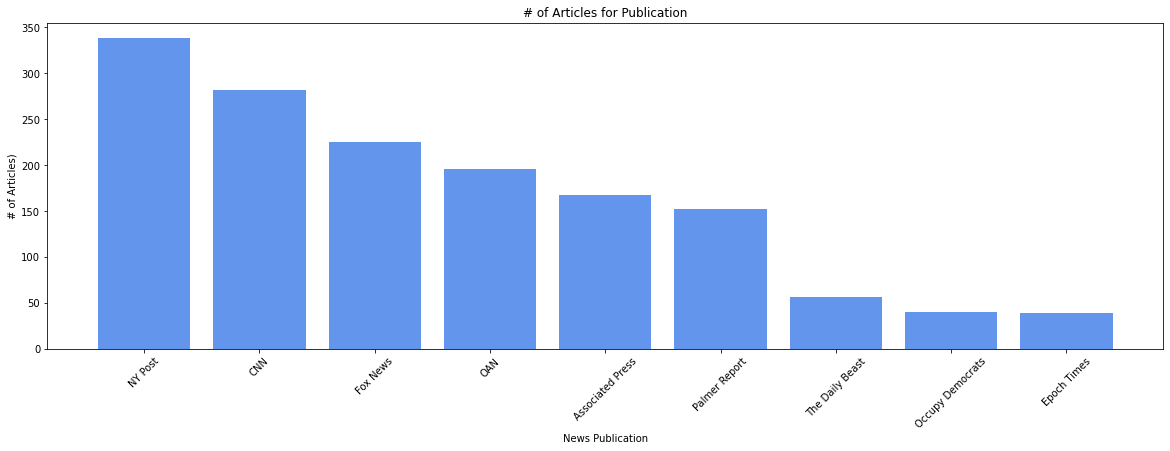

In [4]:
source = dframe["Source"].value_counts().keys().tolist()
counts = dframe["Source"].value_counts().tolist()

x = source
y = counts

figure = plt.figure(figsize=(20,6))

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='cornflowerblue')
plt.xlabel("News Publication")
plt.ylabel("# of Articles)")
plt.title("# of Articles for Publication")

plt.xticks(x_pos, x, rotation=45)

plt.show()

## Articles by Leaning

The dataset is broken down by number of articles by political leaning:

In [5]:
value_counts_percentage(df=dframe, feature="Leaning")

,Counts,Fraction,Percentage
Right,798,0.534137,53.41%
Left,529,0.354083,35.41%
Middle,167,0.111780,11.18%


Most of the data is right-leaning news articles at a bit of half of the total data. This data is expressed as a bar plot:

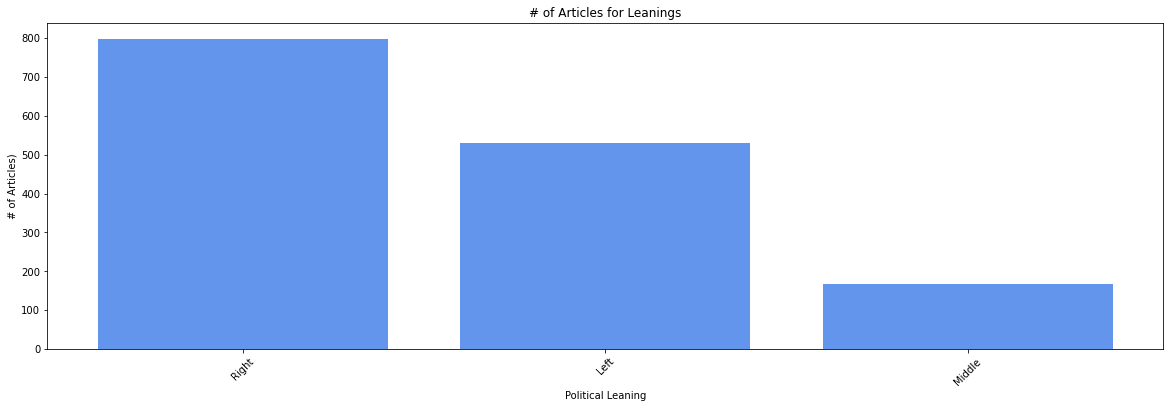

In [6]:
leaning = dframe["Leaning"].value_counts().keys().tolist()
counts = dframe["Leaning"].value_counts().tolist()

x = leaning
y = counts

figure = plt.figure(figsize=(20,6))

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='cornflowerblue')
plt.xlabel("Political Leaning")
plt.ylabel("# of Articles)")
plt.title("# of Articles for Leanings")

plt.xticks(x_pos, x, rotation=45)

plt.show()

# Reliability and Bias Distribution<a id="bias"></a>

The publisher bias and reliability data can be plotted as a scatter plot, in a similar way to the static/interactive Ad Fontes Media Bias chart. This chart will allow us to see the distribution of the news sources used herein:

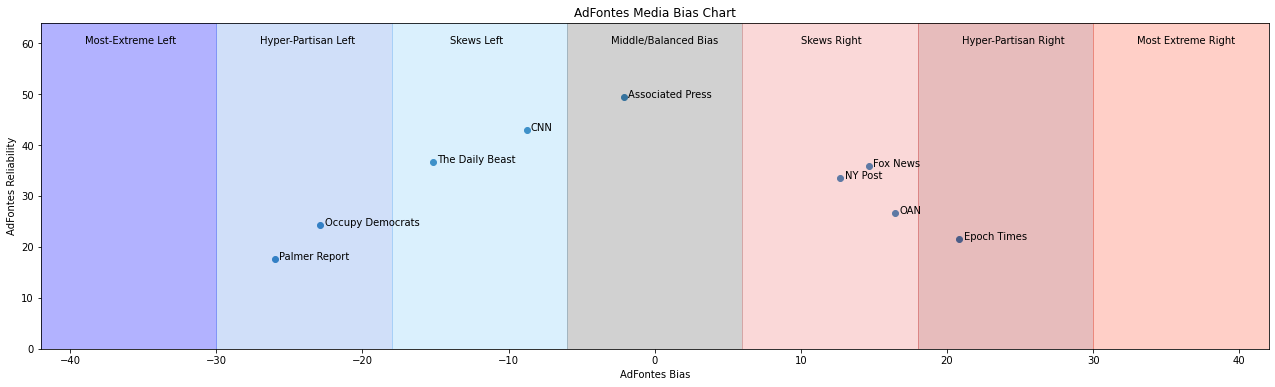

In [7]:
annot = list(adfontes_bias.keys())
x = list(adfontes_bias.values())
y = list(adfontes_reliability.values())
figure = plt.figure(figsize=(22,6))

x_pos = [i for i, _ in enumerate(x)]

annotations = annot

plt.scatter(x, y)
plt.ylabel("AdFontes Reliability")
plt.xlabel("AdFontes Bias")
plt.title("AdFontes Media Bias Chart")

for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]+0.3, y[i]))

plt.annotate("Most-Extreme Left", (-39, 60))
plt.annotate("Hyper-Partisan Left", (-27, 60))
plt.annotate("Skews Left", (-14, 60))
plt.annotate("Middle/Balanced Bias", (-3, 60))

plt.annotate("Skews Right", (10, 60))
plt.annotate("Hyper-Partisan Right", (21, 60))
plt.annotate("Most Extreme Right", (33, 60))

ax = plt.gca()
ax.set_ylim([0, 64])
ax.set_xlim([-42, 42])

ax.axvspan(-42, -30, alpha=0.3, color='blue', label="Most Extreme Left")
ax.axvspan(-30, -18, alpha=0.3, color='cornflowerblue', label="Hyper-Partisan Left")
ax.axvspan(-18, -6, alpha=0.3, color='lightskyblue', label="Skews Left")
ax.axvspan(-6, 6, alpha=0.3, color='dimgray', label="Middle")
ax.axvspan(6, 18, alpha=0.3, color='lightcoral', label="Skews Right")
ax.axvspan(18, 30, alpha=0.3, color='firebrick', label="Hyper-Partisan Right")
ax.axvspan(30, 42, alpha=0.3, color='tomato', label="Most Extreme Right")

plt.show()

The bias categories from the Ad Fontes Media Bias Chart are replicated herein. Of nine total sources, one is in the middle, three skew right, two skew left, two are hyper-partisan left, and one is hyper-partisan right.

# Word Count<a id="wordcount"></a>

The word count of each headline and article content is determined. This short analysis is to see if there is a correlation between publisher and headline/content length.

## Headline and Article Content Length

In [8]:
dframe = word_count(df=dframe, feature="Headline")
dframe = word_count(df=dframe, feature="Content")

In [9]:
dframe.groupby(["Source"]).mean()

,Leaning Encode,Headline Length,Content Length
Source,,,
Associated Press,2.0,10.335329,782.802395
CNN,0.0,12.825623,827.270463
Epoch Times,1.0,10.512821,522.717949
Fox News,1.0,12.737778,617.142222
NY Post,1.0,11.071006,448.112426
OAN,1.0,10.362245,462.505102
Occupy Democrats,0.0,12.500000,603.475000
Palmer Report,0.0,9.572368,352.164474
The Daily Beast,0.0,10.267857,910.500000


In [10]:
print("Mean headline length over all data: ", np.mean(dframe["Headline Length"]))
print("Mean content length over all data: ", np.mean(dframe["Content Length"]))

Mean headline length over all data:  11.317938420348058
Mean content length over all data:  597.8601070950468


The average headline length is about 10-13 words per document per publisher. This value stays somewhat constant. The average content length varies much more. The Daily Beast has the longest articles, on average, with 910.5 words per document. The Palmer Report has the shortest articles, on average, with 352.2 words per document.

The mean headline length over all data is about 11.32 words per headline. The mean content length over all data is about 598 words per article.

A histogram of the headline and article lengths are created to visualize the distribution relative to the mean:

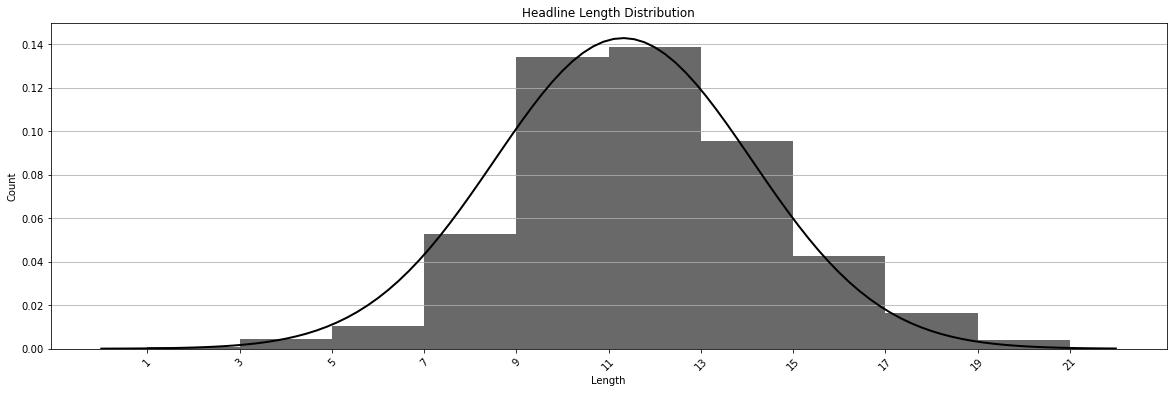

In [11]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1, 1, 1)
counts, bins, patches = axes.hist(dframe["Headline Length"], color="dimgray", align="mid", density=True)
axes.set_xticks(bins)
plt.xticks(rotation=45)
axes.set_title("Headline Length Distribution")
axes.set_xlabel("Length")
axes.set_ylabel("Density")
axes.yaxis.grid(b=True, which="major")

mu = np.mean(dframe["Headline Length"])
std = np.std(dframe["Headline Length"])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)


plt.show()
plt.close()

The distirbution of headline length appears to follow that of a Gaussian/Normal distribution.

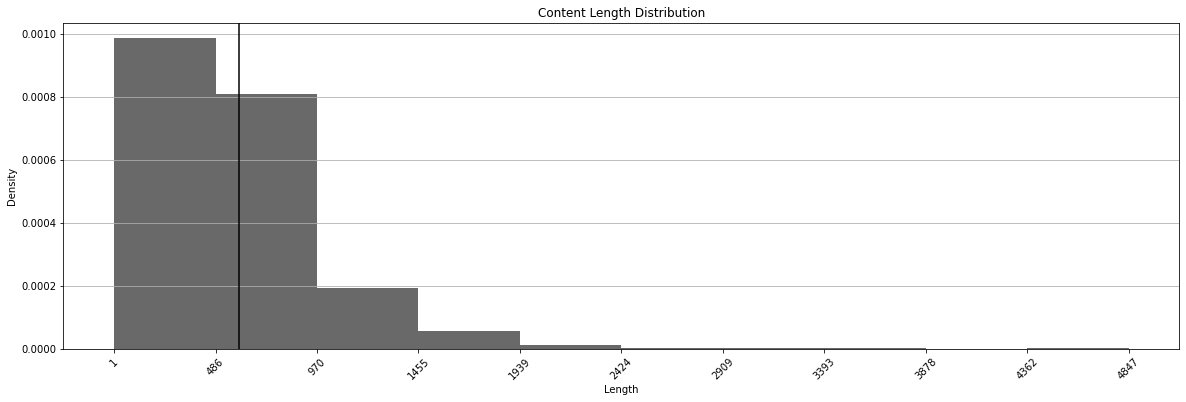

In [12]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1, 1, 1)
counts, bins, patches = axes.hist(dframe["Content Length"], color="dimgray", align="mid", density=True)
axes.set_xticks(bins)
plt.xticks(rotation=45)
axes.set_title("Content Length Distribution")
axes.set_xlabel("Length")
axes.set_ylabel("Density")
axes.yaxis.grid(b=True, which="major")
axes.axvline(x=598, color="k")
plt.show()
plt.close()

The distribution of article length appears to be similar to a Gamma distribution.

## Headline vs. Article Content Length

Intuition suggests that a longer headline is likely needed to accurately capture a more complex news topic. As a result, the article content would also be longer if the topic is complex or confusing. The relationship between content length and headline length is examined:

Trendline: y = 11.988042736285616x + 462.1801776252655


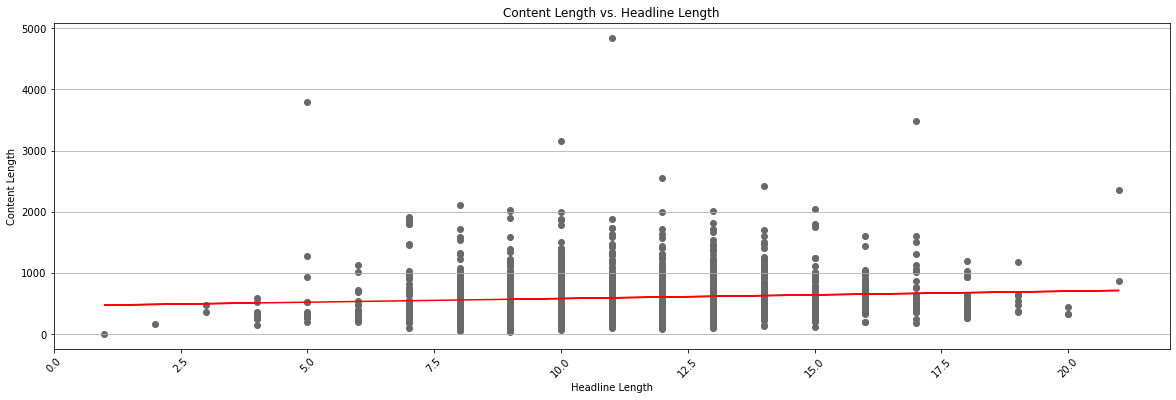

In [13]:
m, b = np.polyfit(dframe["Headline Length"], dframe["Content Length"], 1)

print("Trendline: y = {0}x + {1}".format(m, b))

figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1, 1, 1)
plt.scatter(dframe["Headline Length"], dframe["Content Length"], color="dimgray")
plt.plot(dframe["Headline Length"], m*dframe["Headline Length"] + b, color="red")
plt.xticks(rotation=45)
axes.set_title("Content Length vs. Headline Length")
axes.set_xlabel("Headline Length")
axes.set_ylabel("Content Length")
axes.yaxis.grid(b=True, which="major")
plt.show()
plt.close()

There appears to be a slight positive trend - meaning that as headline length increases, content length also appears to increase, generally speaking.

# Data Normalization<a id="normalization"></a>

The headline and article content data is normalized (case-folding, stop word removal, punctuation removal, and lemmatization) for further analysis.

The built-in NLTK English stop word list is used alongisde the WordNet lemmatizer.

In [14]:
dframe = normalize_data(df=dframe, feature="Headline", lemma=True)
dframe = normalize_data(df=dframe, feature="Content", lemma=True)

In [15]:
dframe.head()

,Source,Headline,Content,Date,Leaning,Leaning Encode,Headline Length,Content Length,Normalized Headline,Normalized Content
0,Associated Press,"For Nebraska Rep. Fortenberry, a two-sided cha...","LINCOLN, Neb. -- When he seeks office again i...",11/15/21,Middle,2,9,817,nebraska rep fortenberry two sided challenge 2022,lincoln neb seek office 2022 u rep jeff forten...
1,Associated Press,Former New Orleans mayor Landrieu to manage Bi...,WASHINGTON -- President Joe Biden has chosen ...,11/15/21,Middle,2,10,295,former new orleans mayor landrieu manage biden...,washington president joe biden chosen supervis...
2,Associated Press,Alzheimer's drug cited as Medicare premium jum...,"WASHINGTON -- Medicare's ""Part B"" outpatient ...",11/15/21,Middle,2,9,739,alzheimers drug cited medicare premium jump 2160,washington medicare part b outpatient premium ...
3,Associated Press,Buttigieg's star rises as $1T Biden agenda shi...,"WASHINGTON -- Pete Buttigieg, the transportat...",11/15/21,Middle,2,10,1212,buttigiegs star rise 1t biden agenda shift toward,washington pete buttigieg transportation secre...
4,Associated Press,Inside DNC chair's 'challenging' bid to avert ...,He's not particularly close to the White House...,11/15/21,Middle,2,9,2019,inside dnc chair challenging bid avert midterm...,he particularly close white house he never sta...


# Topic Modeling<a id="topics"></a>

Two popular approaches to topic modeling are used herein - Latent Dirichlect Allocation (LDA) and Non-negative Matrix Factorization (NMF). The topic modeling using LDA and NMF were done following a similar task documented in [this TowardsDataScience article](https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d).

## Latent Dirichlect Allocation (LDA)

The documents are vectorized using scikit-learn's `CountVectorizer`, and an LDA model is created. 10 components (topics) are created and shown with corresponding keywords.

In [16]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(dframe["Normalized Content"].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()

In [17]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)

In [18]:
display_topics(lda_model, tf_feature_names)

Topic 0:
said vaccine border covid 19 migrant state official russia mandate
Topic 1:
biden president house white said china harris administration vice american
Topic 2:
republican democrat house bill senate party said vote president democratic
Topic 3:
said would year price biden billion american climate inflation cost
Topic 4:
trump one people like said going even right know would
Topic 5:
trump committee court house president bannon former justice january capitol
Topic 6:
said government military country 2021 reuters minister reporting state protest
Topic 7:
state said school law news texas governor public right also
Topic 8:
said police year told prison according time family old officer
Topic 9:
rittenhouse 2021 black white november kenosha kyle verdict america wisconsin


The above topics are categorized as such, and each document is labeled with the according topic as predicted by LDA:

In [19]:
lda_remap = {0: "COVID-19/Vaccine",
             1: "Biden",
             2: "House/Senate",
             3: "Inflation/Infrustructure",
             4: "Trump",
             5: "Insurrection",
             6: "Government/Military",
             7: "Laws",
             8: "Police",
             9: "US Trials/Court Cases"}

lda_topic_values = lda_model.transform(tf)
dframe['LDA_topics'] = lda_topic_values.argmax(axis=1)
dframe['LDA_topics'] = dframe['LDA_topics'].map(lda_remap)

The distribution of LDA topics:

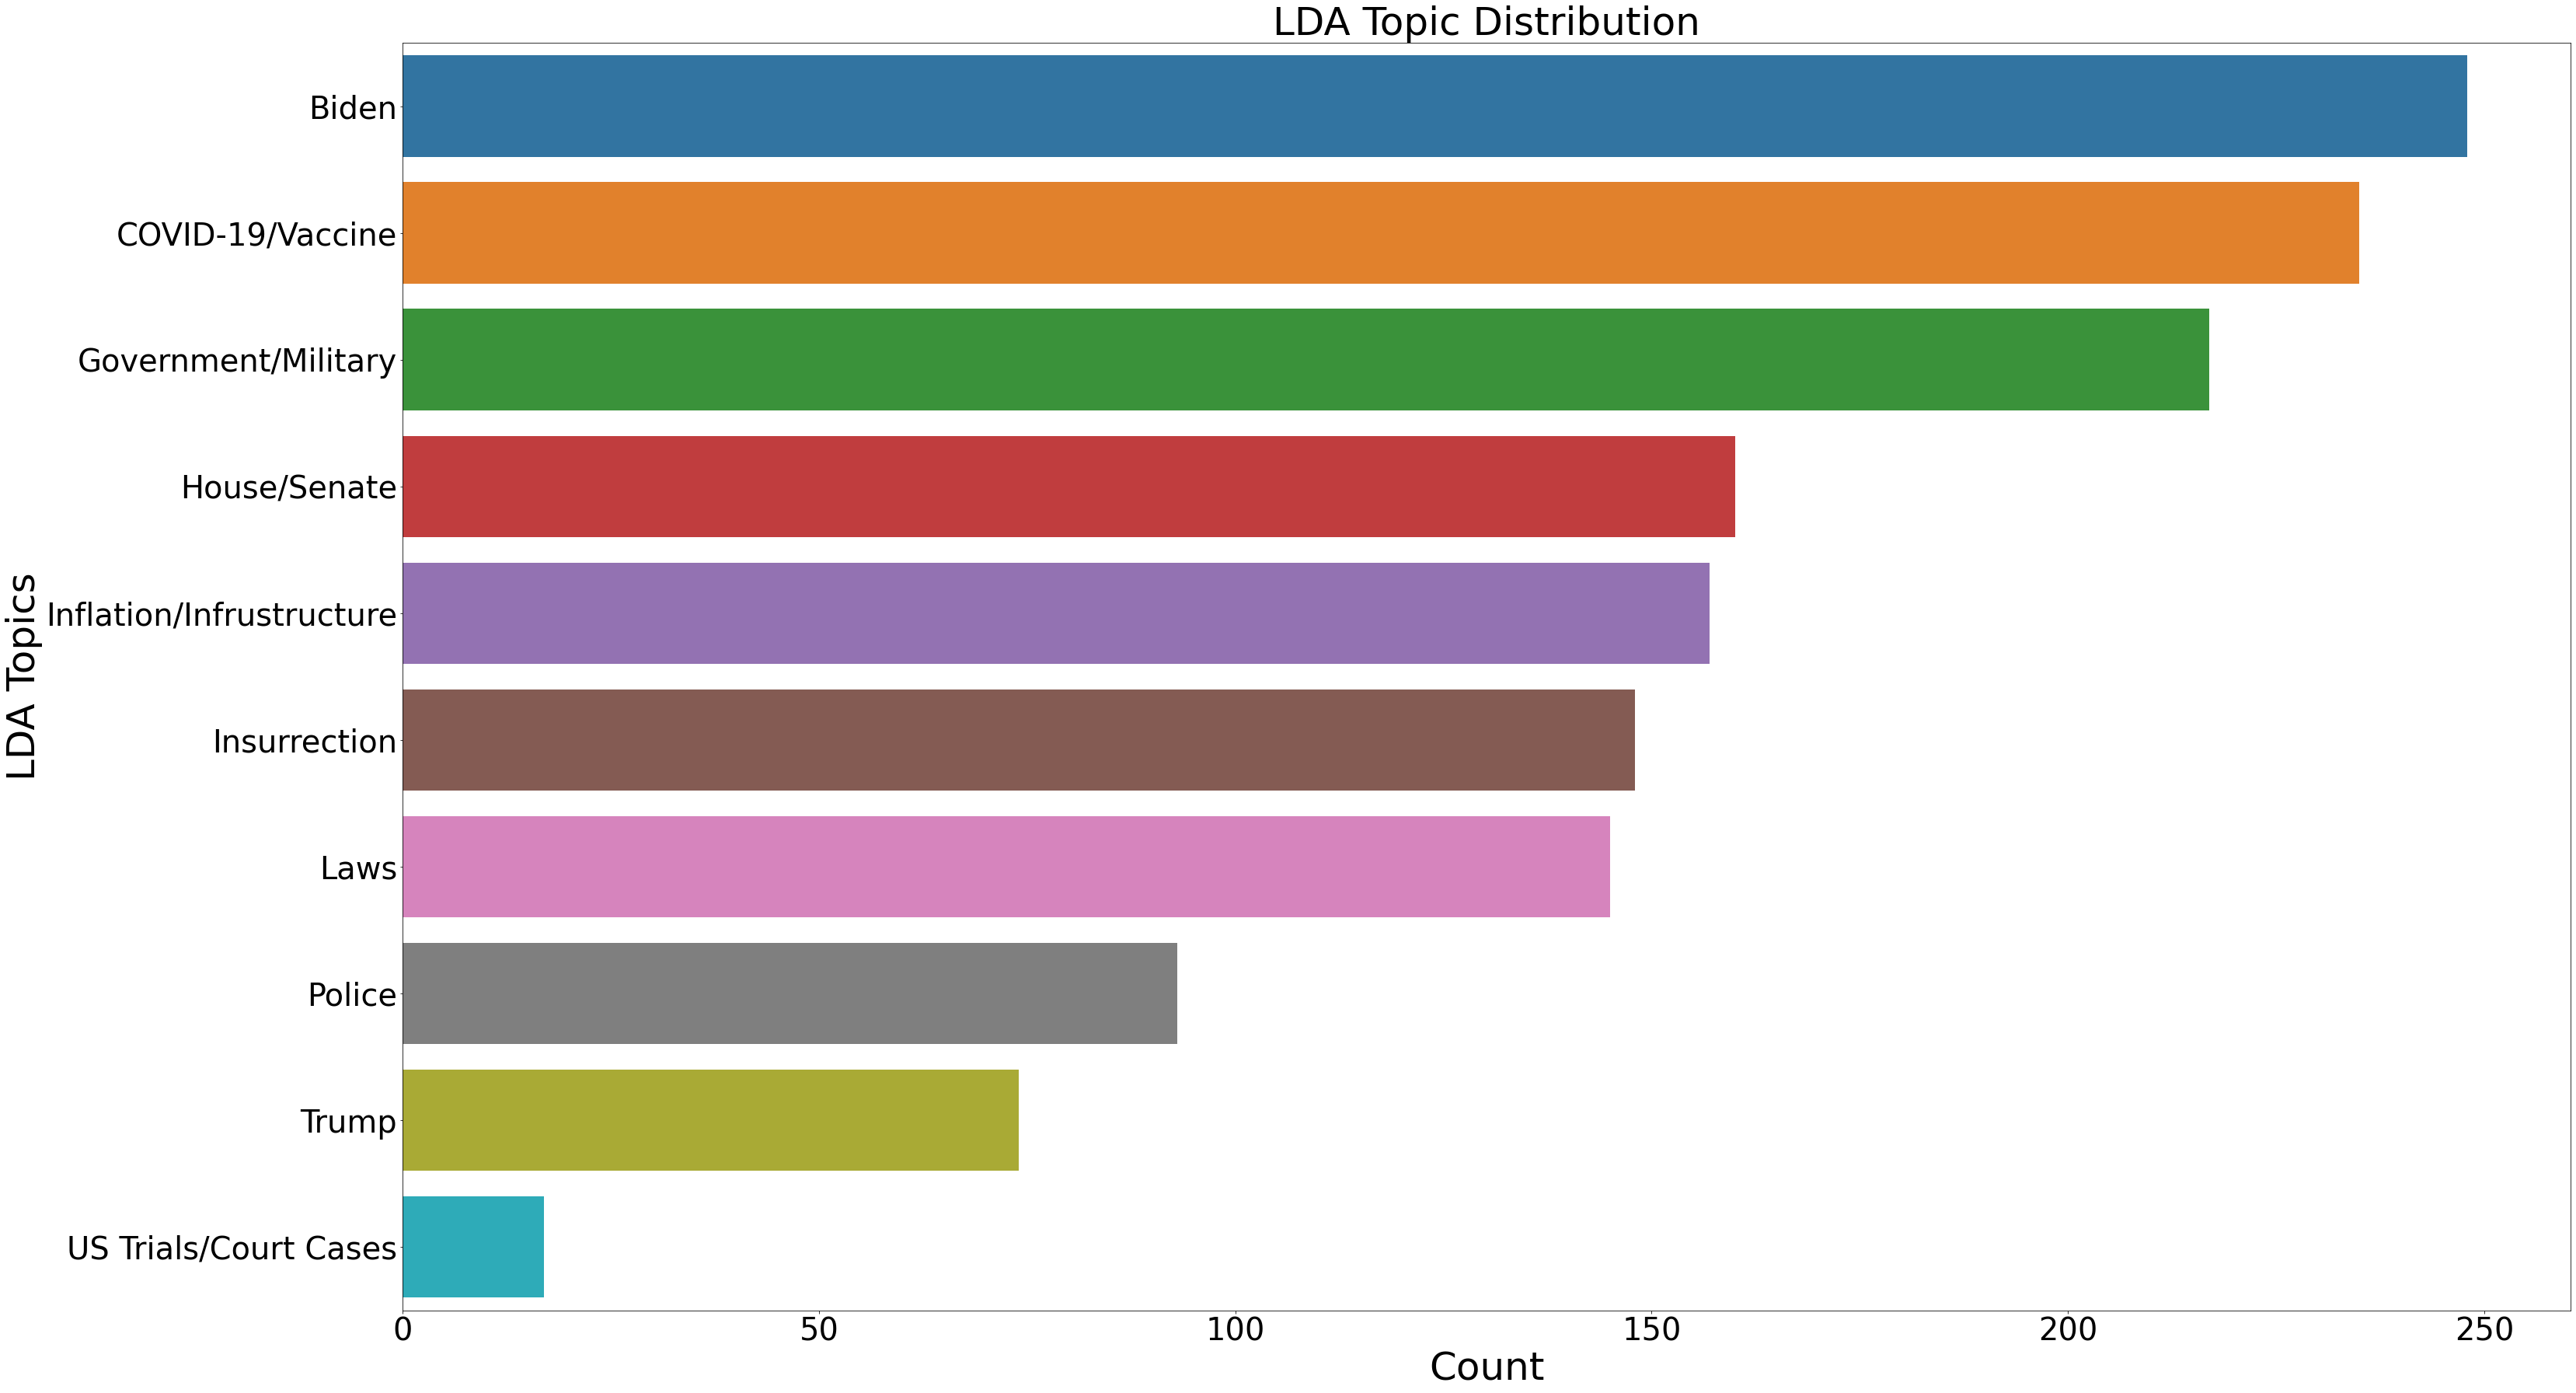

In [20]:
plt.figure(figsize=(50,30))
sns.barplot(dframe['LDA_topics'].value_counts(), dframe['LDA_topics'].value_counts().sort_index().index)
plt.title("LDA Topic Distribution", fontsize=50)
plt.ylabel('LDA Topics', fontsize=50)
plt.yticks(fontsize=40);
plt.xlabel('Count', fontsize=50)
plt.xticks(fontsize=40);

## Non-negative Matrix Factorization (NMF)

The documents are vectorized using scikit-learn's `TfidfVectorizer`, and a NMF model is created. 10 components (topics) are created and shown with corresponding keywords.

In [21]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(dframe["Normalized Content"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)

In [22]:
display_topics(nmf, tfidf_feature_names)

Topic 0:
bill price democrat infrastructure inflation tax house billion senate spending
Topic 1:
said police year family told prison officer according old school
Topic 2:
trump bannon committee meadow court subpoena privilege contempt january former
Topic 3:
border migrant belarus ukraine russia eu poland russian said crisis
Topic 4:
vaccine mandate covid 19 vaccinated employee vaccination federal court health
Topic 5:
china taiwan xi chinese beijing biden said summit climate meeting
Topic 6:
rittenhouse kenosha kyle verdict arbery trial jury wisconsin shooting black
Topic 7:
republican trump election party candidate state gop democrat texas senate
Topic 8:
gosar mccarthy house rep republican video ocasio censure cortez democrat
Topic 9:
biden harris president white thanksgiving vice house bidens psaki first


The above topics are categorized as such, and each document is labeled with the according topic as predicted by NMF:

In [23]:
nmf_remap = {0: "Inflation/Infrastructure",
             1: "Police",
             2: "Insurrection",
             3: "Border/Migrant/Immgiration",
             4: "COVID-19/Vaccine",
             5: "China",
             6: "US Trials/Court Cases",
             7: "Trump",
             8: "House/Senate",
             9: "Biden"}

In [24]:
nmf_topic_values = nmf.transform(tfidf)
dframe['NMF_topics'] = nmf_topic_values.argmax(axis=1)
dframe['NMF_topics'] = dframe['NMF_topics'].map(nmf_remap)

The distribution of NMF topics:

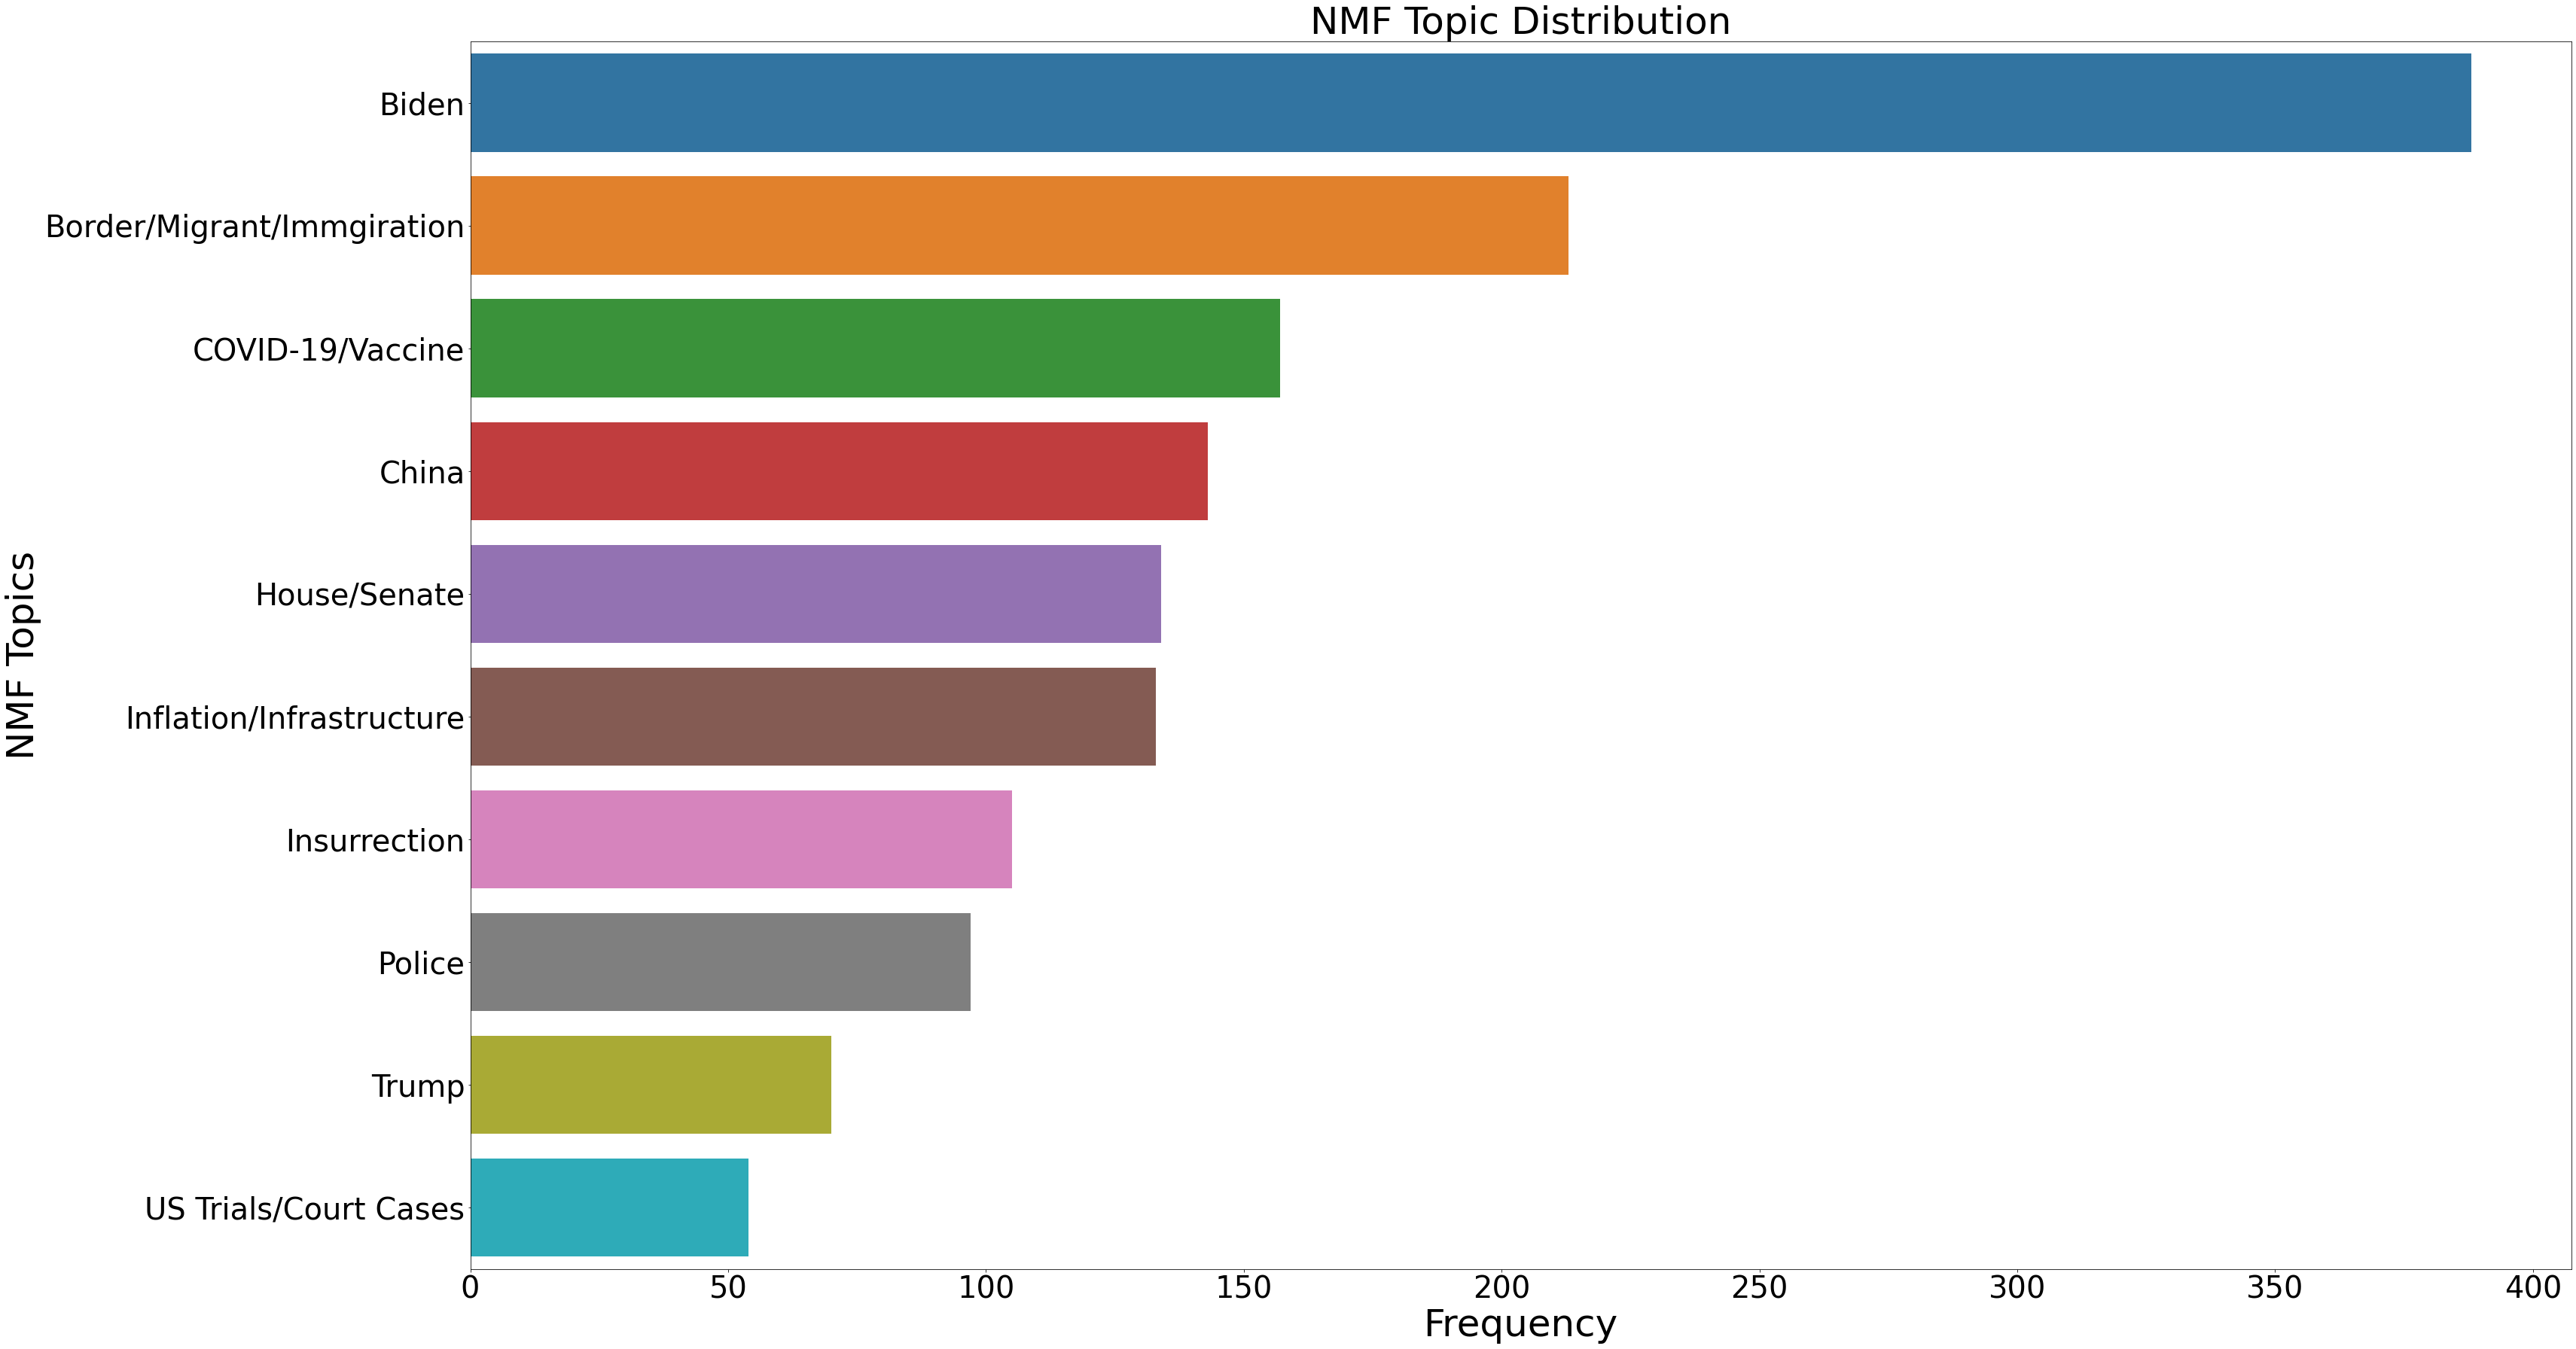

In [25]:
plt.figure(figsize=(50,30))
sns.barplot(dframe['NMF_topics'].value_counts(), dframe['NMF_topics'].value_counts().sort_index().index)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('NMF Topics', fontsize=50)
plt.yticks(fontsize=40);
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40);

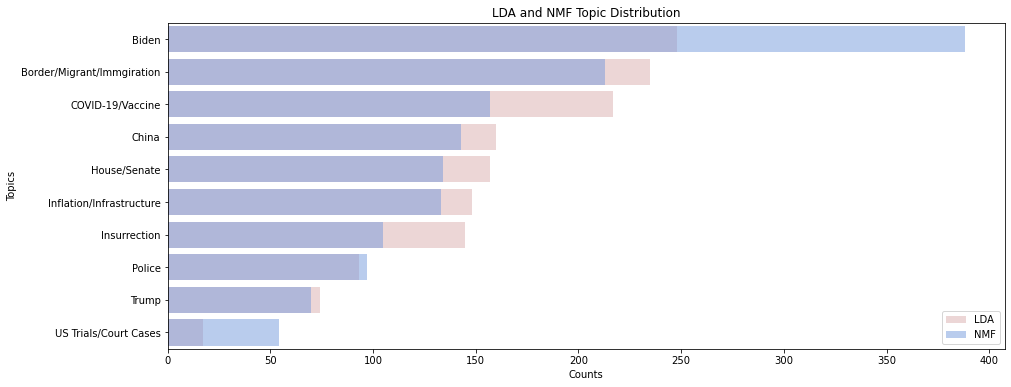

In [62]:
ax = plt.subplots(figsize=(15, 6))

ax = sns.barplot(dframe['LDA_topics'].value_counts(), dframe['LDA_topics'].value_counts().sort_index().index, color='firebrick', alpha=0.2, label="LDA")
ax = sns.barplot(dframe['NMF_topics'].value_counts(), dframe['NMF_topics'].value_counts().sort_index().index, color='cornflowerblue', alpha=0.5, label="NMF")
  
ax.set(title="LDA and NMF Topic Distribution", xlabel="Counts", ylabel="Topics")

plt.legend()
plt.show()

## LDA vs. NMF

The topics output from LDA and NMF differ slightly. The head and tail of the dataset are examined to see if it is possible to discern which of the two models, LDA or NMF, better selects topics for the documents:

In [26]:
dframe.head()

,Source,Headline,Content,Date,Leaning,Leaning Encode,Headline Length,Content Length,Normalized Headline,Normalized Content,LDA_topics,NMF_topics
0,Associated Press,"For Nebraska Rep. Fortenberry, a two-sided cha...","LINCOLN, Neb. -- When he seeks office again i...",11/15/21,Middle,2,9,817,nebraska rep fortenberry two sided challenge 2022,lincoln neb seek office 2022 u rep jeff forten...,House/Senate,Trump
1,Associated Press,Former New Orleans mayor Landrieu to manage Bi...,WASHINGTON -- President Joe Biden has chosen ...,11/15/21,Middle,2,10,295,former new orleans mayor landrieu manage biden...,washington president joe biden chosen supervis...,Inflation/Infrustructure,Inflation/Infrastructure
2,Associated Press,Alzheimer's drug cited as Medicare premium jum...,"WASHINGTON -- Medicare's ""Part B"" outpatient ...",11/15/21,Middle,2,9,739,alzheimers drug cited medicare premium jump 2160,washington medicare part b outpatient premium ...,Inflation/Infrustructure,Inflation/Infrastructure
3,Associated Press,Buttigieg's star rises as $1T Biden agenda shi...,"WASHINGTON -- Pete Buttigieg, the transportat...",11/15/21,Middle,2,10,1212,buttigiegs star rise 1t biden agenda shift toward,washington pete buttigieg transportation secre...,Inflation/Infrustructure,Inflation/Infrastructure
4,Associated Press,Inside DNC chair's 'challenging' bid to avert ...,He's not particularly close to the White House...,11/15/21,Middle,2,9,2019,inside dnc chair challenging bid avert midterm...,he particularly close white house he never sta...,House/Senate,Trump


In [27]:
dframe.tail()

,Source,Headline,Content,Date,Leaning,Leaning Encode,Headline Length,Content Length,Normalized Headline,Normalized Content,LDA_topics,NMF_topics
1489,Palmer Report,Here’s when Donald Trump will end up indicted ...,Here’s the thing about Steve Bannon’s indictme...,11/15/21,Left,0,12,452,here donald trump end indicted contempt congress,here thing steve bannons indictment arrest con...,Insurrection,Insurrection
1490,Palmer Report,"“Man, knock it off!”",Monday is when the attorneys in the Kyle Ritte...,11/15/21,Left,0,4,246,“man knock,monday attorney kyle rittenhouse case make clo...,Trump,US Trials/Court Cases
1491,Palmer Report,Steve Bannon has been indicted. Now what?,Steve Bannon has at last been indicted. As wit...,11/15/21,Left,0,7,638,steve bannon indicted,steve bannon last indicted would liked seen sw...,Trump,Insurrection
1492,Palmer Report,So when will the next January 6th Committee cr...,Yesterday the Department of Justice announced ...,11/15/21,Left,0,11,474,next january 6th committee criminal indictment...,yesterday department justice announced obtaine...,Insurrection,Insurrection
1493,Palmer Report,What doesn’t kill us…,German philosopher Friedrich Nietzsche said : ...,11/15/21,Left,0,4,276,doesnt kill us…,german philosopher friedrich nietzsche said “w...,Trump,Biden


The head and tail are too small of data points to determine which approach better selects topics. Both sets of topics will be considered moving forward when creating a classification model.

# Word Clouds<a id="wordcloud"></a>

## Headline Data WordCloud

In [28]:
left = dframe[dframe["Leaning"] == "Left"]
right = dframe[dframe["Leaning"] == "Right"]
middle = dframe[dframe["Leaning"] == "Middle"]
left.reset_index(drop=True, inplace=True)
right.reset_index(drop=True, inplace=True)
middle.reset_index(drop=True, inplace=True)

In [29]:
left_text, left_split = cat_text(df=left, feature="Normalized Headline")
right_text, right_split = cat_text(df=right, feature="Normalized Headline")
middle_text, middle_split = cat_text(df=middle, feature="Normalized Headline")

## Headline Data WordCloud

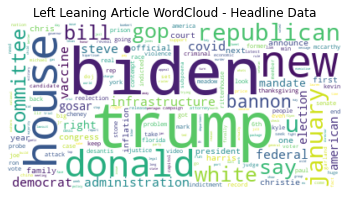

In [30]:
generate_wordcloud(data=left_text, title="Left Leaning Article WordCloud - Headline Data")

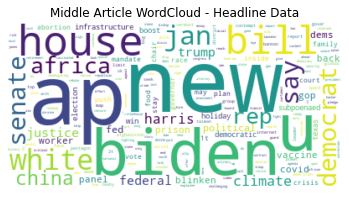

In [31]:
generate_wordcloud(data=middle_text, title="Middle Article WordCloud - Headline Data")

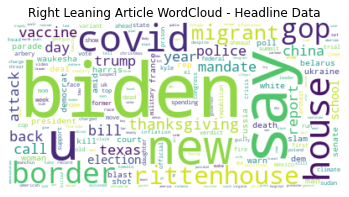

In [32]:
generate_wordcloud(data=right_text, title="Right Leaning Article WordCloud - Headline Data")

## Article Data WordCloud

In [33]:
left_text, left_split = cat_text(df=left, feature="Normalized Content")
right_text, right_split = cat_text(df=right, feature="Normalized Content")
middle_text, middle_split = cat_text(df=middle, feature="Normalized Content")

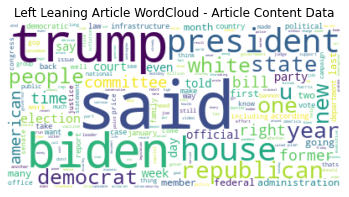

In [34]:
generate_wordcloud(data=left_text, title="Left Leaning Article WordCloud - Article Content Data")

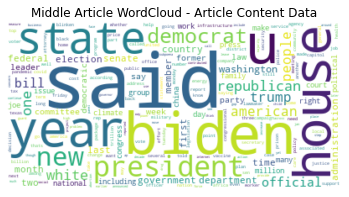

In [35]:
generate_wordcloud(data=middle_text, title="Middle Article WordCloud - Article Content Data")

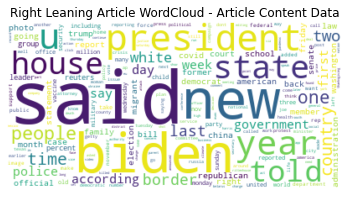

In [36]:
generate_wordcloud(data=right_text, title="Right Leaning Article WordCloud - Article Content Data")

# Sentiment Analysis - Polarity<a id="sentiment"></a>

## Polarity Distribution

In [37]:
dframe["Headline Polarity"] = dframe["Normalized Headline"].apply(lambda x: TextBlob(x).sentiment.polarity)
dframe["Content Polarity"] = dframe["Normalized Content"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [38]:
dframe.head()

,Source,Headline,Content,Date,Leaning,Leaning Encode,Headline Length,Content Length,Normalized Headline,Normalized Content,LDA_topics,NMF_topics,Headline Polarity,Content Polarity
0,Associated Press,"For Nebraska Rep. Fortenberry, a two-sided cha...","LINCOLN, Neb. -- When he seeks office again i...",11/15/21,Middle,2,9,817,nebraska rep fortenberry two sided challenge 2022,lincoln neb seek office 2022 u rep jeff forten...,House/Senate,Trump,0.000000,0.072480
1,Associated Press,Former New Orleans mayor Landrieu to manage Bi...,WASHINGTON -- President Joe Biden has chosen ...,11/15/21,Middle,2,10,295,former new orleans mayor landrieu manage biden...,washington president joe biden chosen supervis...,Inflation/Infrustructure,Inflation/Infrastructure,0.068182,0.115488
2,Associated Press,Alzheimer's drug cited as Medicare premium jum...,"WASHINGTON -- Medicare's ""Part B"" outpatient ...",11/15/21,Middle,2,9,739,alzheimers drug cited medicare premium jump 2160,washington medicare part b outpatient premium ...,Inflation/Infrustructure,Inflation/Infrastructure,0.000000,0.031020
3,Associated Press,Buttigieg's star rises as $1T Biden agenda shi...,"WASHINGTON -- Pete Buttigieg, the transportat...",11/15/21,Middle,2,10,1212,buttigiegs star rise 1t biden agenda shift toward,washington pete buttigieg transportation secre...,Inflation/Infrustructure,Inflation/Infrastructure,0.000000,0.147375
4,Associated Press,Inside DNC chair's 'challenging' bid to avert ...,He's not particularly close to the White House...,11/15/21,Middle,2,9,2019,inside dnc chair challenging bid avert midterm...,he particularly close white house he never sta...,House/Senate,Trump,0.500000,0.055720


In [39]:
dframe.groupby(["Source"]).mean()

,Leaning Encode,Headline Length,Content Length,Headline Polarity,Content Polarity
Source,,,,,
Associated Press,2.0,10.335329,782.802395,0.041180,0.056062
CNN,0.0,12.825623,827.270463,0.017007,0.057534
Epoch Times,1.0,10.512821,522.717949,0.028113,0.039446
Fox News,1.0,12.737778,617.142222,0.013420,0.041371
NY Post,1.0,11.071006,448.112426,0.006162,0.023943
OAN,1.0,10.362245,462.505102,-0.010267,0.018766
Occupy Democrats,0.0,12.500000,603.475000,0.008030,0.023988
Palmer Report,0.0,9.572368,352.164474,-0.021041,0.054047
The Daily Beast,0.0,10.267857,910.500000,0.020426,0.047928


In [40]:
dframe.groupby(["Leaning"]).mean()

,Leaning Encode,Headline Length,Content Length,Headline Polarity,Content Polarity
Leaning,,,,,
Left,0.0,11.595463,682.644612,0.005758,0.052979
Middle,2.0,10.335329,782.802395,0.041180,0.056062
Right,1.0,11.339599,502.952381,0.005246,0.028343


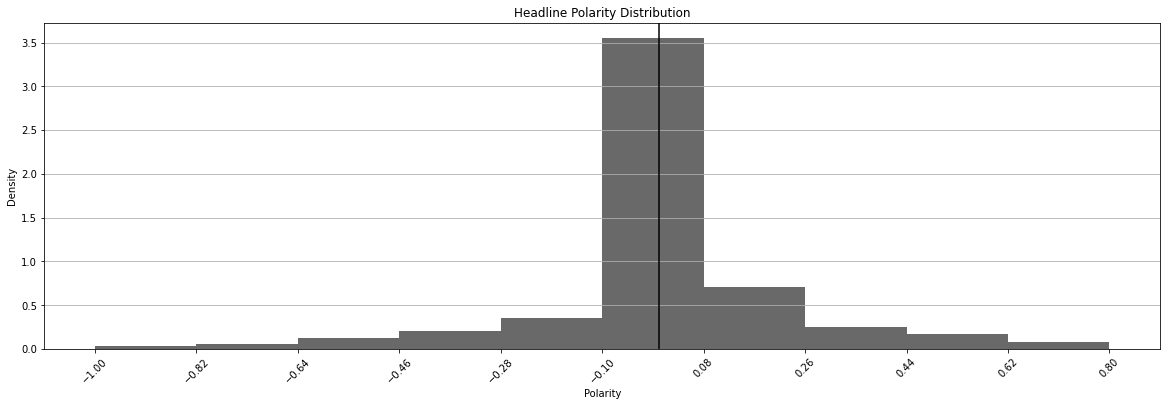

In [63]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1, 1, 1)
counts, bins, patches = axes.hist(dframe["Headline Polarity"], color="dimgray", align="mid", density=True)
axes.set_xticks(bins)
plt.xticks(rotation=45)
axes.set_title("Headline Polarity Distribution")
axes.set_xlabel("Polarity")
axes.set_ylabel("Density")
axes.yaxis.grid(b=True, which="major")
axes.axvline(x=0.0, color="k")
plt.show()
plt.close()

In [42]:
polarity = dframe.sort_values(by=["Headline Polarity"],ascending=True)[:5]
polarity["Headline"]

952     Lauren Boebert’s cruel proposal to her wheelch...
968      Mike Lindell Trolls Fox News With Pathetic Rally
962       The War on Thanksgiving Is America at Its Worst
1470                                    The party of evil
1265    Man admits to killing grandma in shocking Trut...
Name: Headline, dtype: object

In [43]:
polarity = dframe.sort_values(by=["Headline Polarity"],ascending=False)[:5]
polarity["Headline"]

1022    Trump hints at 2024 bid in Thanksgiving messag...
820     Boeing knew doomed 737-MAX plane was ‘pig with...
700     Virginia AG-elect vows to investigate Loudoun ...
1409    Was Glasgow pact a win for climate? Time will ...
1472    Donald Trump’s January 6th co-conspirators are...
Name: Headline, dtype: object

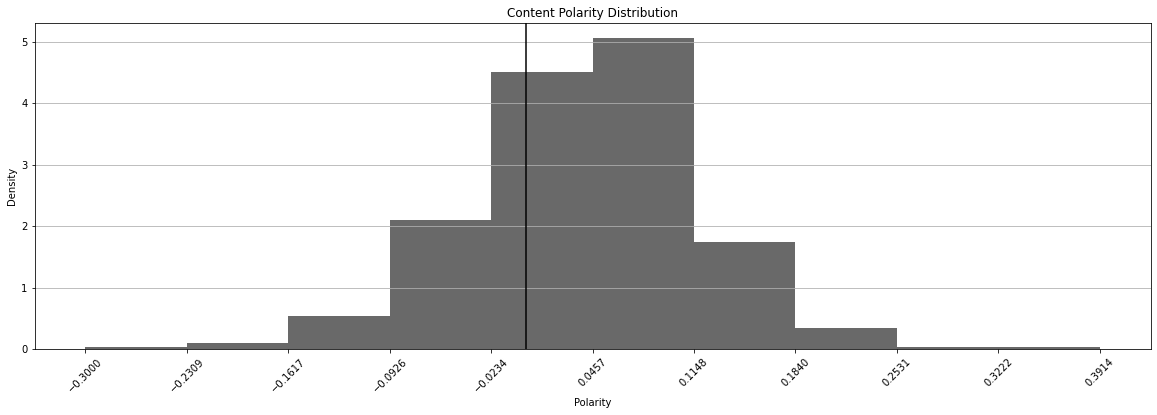

In [44]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1, 1, 1)
counts, bins, patches = axes.hist(dframe["Content Polarity"], color="dimgray", align="mid", density=True)
axes.set_xticks(bins)
plt.xticks(rotation=45)
axes.set_title("Content Polarity Distribution")
axes.set_xlabel("Polarity")
axes.set_ylabel("Density")
axes.yaxis.grid(b=True, which="major")
axes.axvline(x=0.0, color="k")
plt.show()
plt.close()

In [45]:
polarity = dframe.sort_values(by=["Content Polarity"],ascending=True)[:5]
polarity["Content"]

516     At least two people were arrested at gunpoint ...
1310    Five inmates with “violent criminal histories”...
191       Five inmates have reportedly escaped from a ...
788     The law professor weighed in on the high-profi...
1484    Whenever a corrupt Republican politician does ...
Name: Content, dtype: object

In [46]:
polarity = dframe.sort_values(by=["Content Polarity"],ascending=False)[:5]
polarity["Content"]

950     Although it is indeed wonderful to have compet...
601     Have you ever danced in the rain? I have, and ...
1471    Beneath the turquoise waves of the ocean, ther...
940     I’ve always thought that Donald Trump and the ...
1010    Walmart has launched an instant drone delivery...
Name: Content, dtype: object

Trendline: y = 0.07661965828507794x + 0.039440918950063276


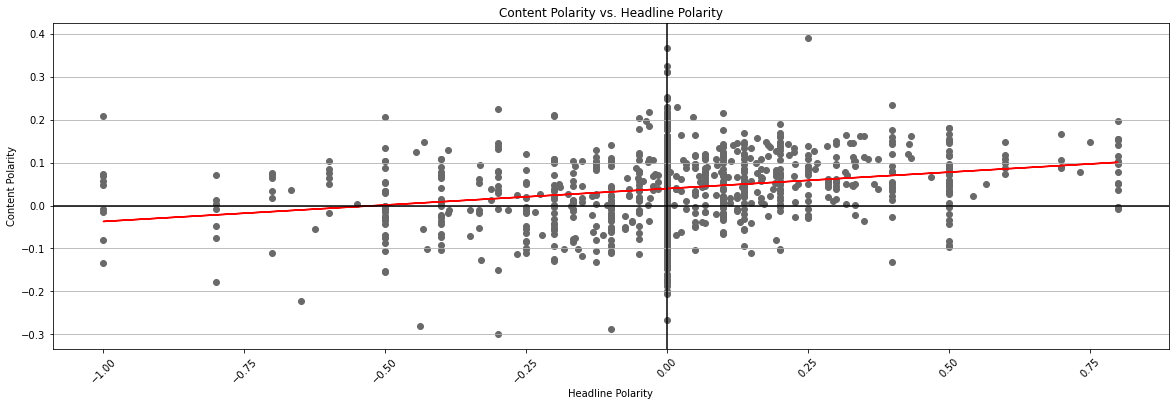

In [47]:
m, b = np.polyfit(dframe["Headline Polarity"], dframe["Content Polarity"], 1)

print("Trendline: y = {0}x + {1}".format(m, b))

figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1, 1, 1)
plt.scatter(dframe["Headline Polarity"], dframe["Content Polarity"], color="dimgray")
plt.plot(dframe["Headline Polarity"], m*dframe["Headline Polarity"] + b, color="red")
plt.xticks(rotation=45)
axes.set_title("Content Polarity vs. Headline Polarity")
axes.set_xlabel("Headline Polarity")
axes.set_ylabel("Content Polarity")
axes.yaxis.grid(b=True, which="major")
axes.axvline(x=0.0, color="k")
axes.axhline(y=0.0, color="k")
plt.show()
plt.close()

## Polarity Distribution by Leaning

In [48]:
left = dframe[dframe["Leaning"] == "Left"]
middle = dframe[dframe["Leaning"] == "Middle"]
right = dframe[dframe["Leaning"] == "Right"]

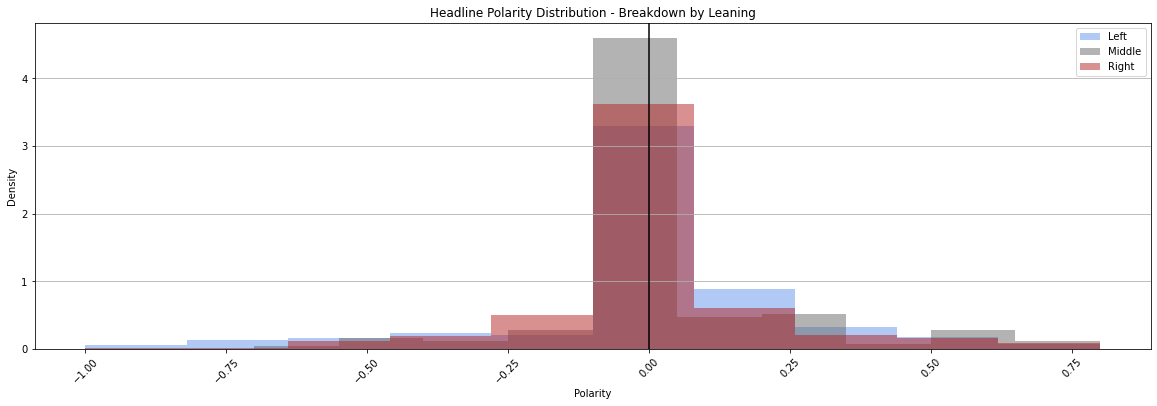

In [49]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1, 1, 1)
counts, bins, patches = axes.hist(left["Headline Polarity"], color="cornflowerblue", align="mid", alpha=0.5, label="Left", density=True)
counts, bins, patches = axes.hist(middle["Headline Polarity"], color="dimgray", align="mid", alpha=0.5, label="Middle", density=True)
counts, bins, patches = axes.hist(right["Headline Polarity"], color="firebrick", align="mid", alpha=0.5, label="Right", density=True)
#axes.set_xticks(bins)
plt.xticks(rotation=45)
axes.set_title("Headline Polarity Distribution - Breakdown by Leaning")
axes.set_xlabel("Polarity")
axes.set_ylabel("Density")
axes.yaxis.grid(b=True, which="major")
axes.axvline(x=0.0, color="k")
plt.legend()
plt.show()
plt.close()

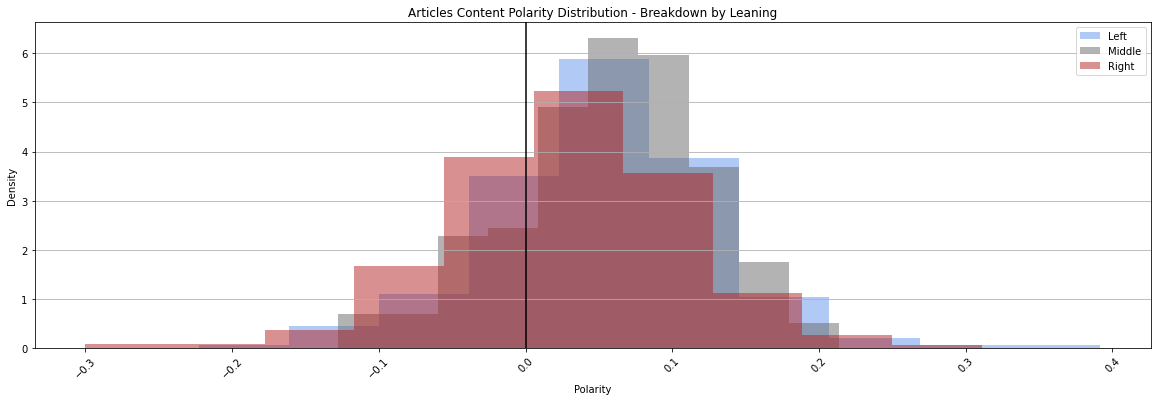

In [50]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1, 1, 1)
counts, bins, patches = axes.hist(left["Content Polarity"], color="cornflowerblue", align="mid", alpha=0.5, label="Left", density=True)
counts, bins, patches = axes.hist(middle["Content Polarity"], color="dimgray", align="mid", alpha=0.5, label="Middle", density=True)
counts, bins, patches = axes.hist(right["Content Polarity"], color="firebrick", align="mid", alpha=0.5, label="Right", density=True)
#axes.set_xticks(bins)
plt.xticks(rotation=45)
axes.set_title("Articles Content Polarity Distribution - Breakdown by Leaning")
axes.set_xlabel("Polarity")
axes.set_ylabel("Density")
axes.yaxis.grid(b=True, which="major")
axes.axvline(x=0.0, color="k")
plt.legend()
plt.show()
plt.close()

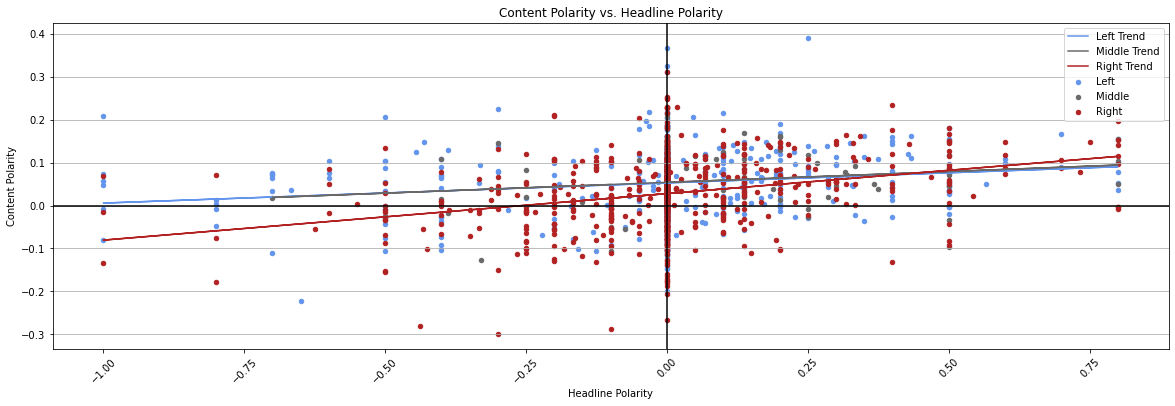

In [51]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1, 1, 1)

m, b = np.polyfit(left["Headline Polarity"], left["Content Polarity"], 1)
plt.plot(left["Headline Polarity"], m*left["Headline Polarity"] + b, color="cornflowerblue", label="Left Trend")

m, b = np.polyfit(middle["Headline Polarity"], middle["Content Polarity"], 1)
plt.plot(middle["Headline Polarity"], m*middle["Headline Polarity"] + b, color="dimgray", label="Middle Trend")

m, b = np.polyfit(right["Headline Polarity"], right["Content Polarity"], 1)
plt.plot(right["Headline Polarity"], m*right["Headline Polarity"] + b, color="firebrick", label="Right Trend")

plt.scatter(left["Headline Polarity"], left["Content Polarity"], color="cornflowerblue", label="Left", s=20)
plt.scatter(middle["Headline Polarity"], middle["Content Polarity"], color="dimgray", label="Middle", s=20)
plt.scatter(right["Headline Polarity"], right["Content Polarity"], color="firebrick", label="Right", s=20)
plt.xticks(rotation=45)
axes.set_title("Content Polarity vs. Headline Polarity")
axes.set_xlabel("Headline Polarity")
axes.set_ylabel("Content Polarity")
axes.yaxis.grid(b=True, which="major")

axes.axvline(x=0.0, color="k")
axes.axhline(y=0.0, color="k")

plt.legend()
plt.show()
plt.close()

# Save Data

The dataset with the EDA performed is saved to a CSV file and will be used as the starting point for ML model development:

In [52]:
dframe.to_csv("news_dataset_EDA.csv", index=None)